In [3]:
# 필요한 라이브러리 임포트
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

#################
# 함수 정의 부분 #
#################

def download_data(tickers):
    data_dict = {}
    # 먼저 모든 데이터 다운로드
    for ticker in tickers:
        data = yf.download(ticker)  # 전체 기간 데이터 다운로드
        if not data.empty:
            data_dict[ticker] = data
    
    # 가장 늦은 시작일 찾기
    start_dates = []
    for ticker, data in data_dict.items():
        start_dates.append(data.index[0])
    latest_start = max(start_dates)
    
    # 현재 날짜를 종료일로 설정
    end_date = datetime.now()
    
    # 동일한 기간으로 데이터 재구성
    prices = pd.DataFrame()
    for ticker in tickers:
        if ticker in data_dict:
            data = data_dict[ticker]['Adj Close'][latest_start:end_date]
            prices[ticker] = data
    
    return prices, latest_start.strftime('%Y-%m-%d')

def get_risk_free_rate():
   """
   미국 10년 국채 수익률을 가져와서 무위험 수익률로 사용
   """
   try:
       treasury = yf.download('^TNX', period='1d')
       rf_rate = treasury['Adj Close'].iloc[-1] / 100  # 백분율을 소수점으로 변환
   except:
       # API 호출 실패시 기본값 사용
       print("국채 수익률 데이터 조회 실패. 최근 10년 국채 평균 수익률 3.5% 사용")
       rf_rate = 0.035
   
   return rf_rate

def calculate_portfolio_metrics(weights, returns, risk_free_rate):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
    
    return portfolio_return, portfolio_risk, sharpe_ratio

def backtest_portfolio(prices, weights):
    returns = prices.pct_change().dropna()
    portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # 성과 지표 계산
    annual_return = portfolio_returns.mean() * 252
    annual_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe = (annual_return - risk_free_rate) / annual_volatility
    sortino = (annual_return - risk_free_rate) / (portfolio_returns[portfolio_returns < 0].std() * np.sqrt(252))
    max_drawdown = (1 - cumulative_returns / cumulative_returns.cummax()).max()
    
    return {
        'cumulative_returns': cumulative_returns,
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'max_drawdown': max_drawdown
    }



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
데이터 시작일: 2017-03-08
[*********************100%%**********************]  1 of 1 completed
현재 무위험 수익률: 4.54%


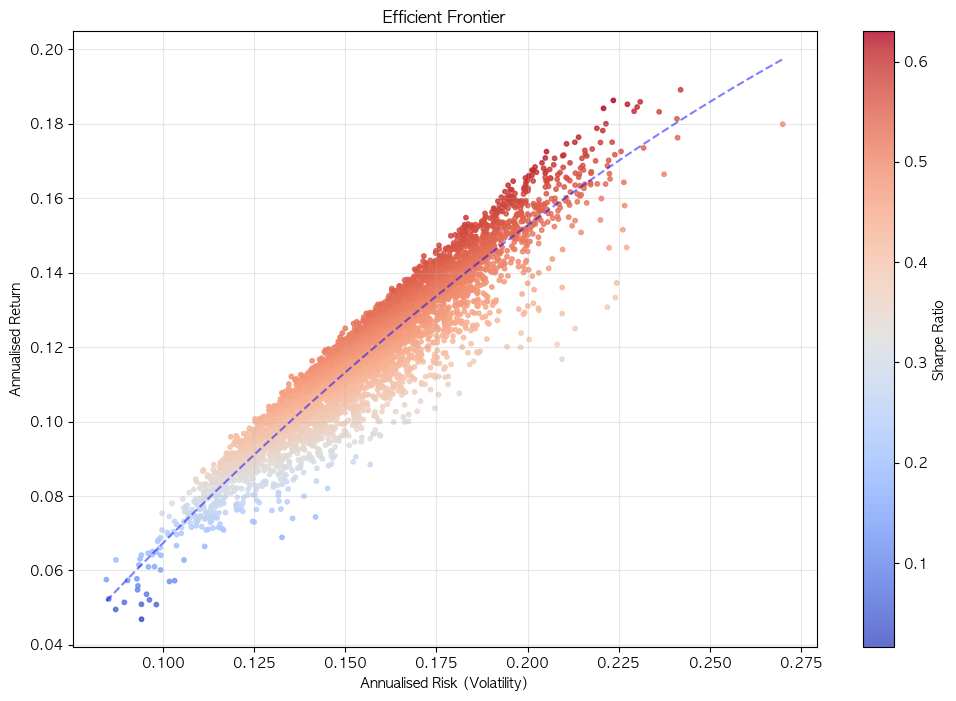


=== 최적 포트폴리오 (최대 샤프 비율) ===
연간 기대수익률: 18.63%
연간 리스크: 22.35%
샤프 비율: 0.63

자산 배분:
IGLB: 5.1%
HYG: 1.3%
SPY: 28.7%
MBB: 1.2%
SOXX: 34.2%
URA: 8.5%
PAVE: 21.0%


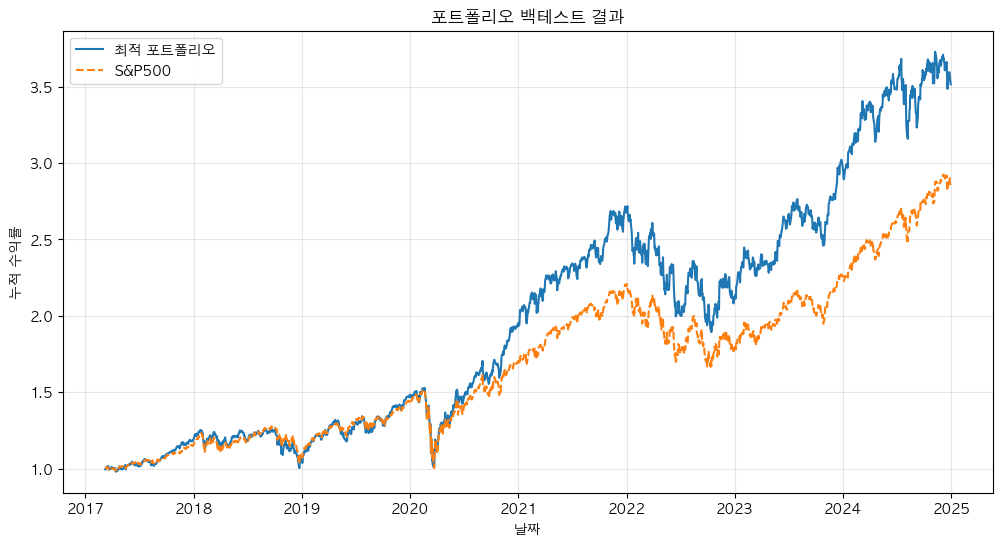


=== 백테스트 성과 비교 ===

최적 포트폴리오:
연간 수익률: 18.63%
연간 변동성: 22.35%
샤프 비율: 0.63
소르티노 비율: 0.81
최대 낙폭: 33.84%

S&P500:
연간 수익률: 15.10%
연간 변동성: 18.54%
샤프 비율: 0.57
소르티노 비율: 0.68
최대 낙폭: 33.72%


In [4]:
#################
# 실행 코드 부분 #
#################

# 분석할 자산 리스트
tickers = ['IGLB', 'HYG', 'SPY', 'MBB', 'SOXX', 'URA', 'PAVE']

# 데이터 로드
prices, start_date = download_data(tickers)
print(f"데이터 시작일: {start_date}")
returns = prices.pct_change().dropna()

# 무위험 수익률 설정 (미국 10년 국채 수익률 가정)
#risk_free_rate = 0.04
risk_free_rate = get_risk_free_rate()
print(f"현재 무위험 수익률: {risk_free_rate*100:.2f}%")

# 몬테카를로 시뮬레이션으로 랜덤 포트폴리오 생성
n_portfolios = 5000
results = np.zeros((n_portfolios, len(tickers) + 3))
for i in range(n_portfolios):
    weights = np.random.random(len(tickers))
    weights = weights/np.sum(weights)
    
    portfolio_return, portfolio_risk, sharpe_ratio = calculate_portfolio_metrics(weights, returns, risk_free_rate)
    
    results[i, :len(tickers)] = weights
    results[i, len(tickers)] = portfolio_return
    results[i, len(tickers) + 1] = portfolio_risk
    results[i, len(tickers) + 2] = sharpe_ratio

# 결과를 데이터프레임으로 변환
columns = tickers + ['returns', 'risk', 'sharpe']
portfolio_results = pd.DataFrame(results, columns=columns)

# 효율적 투자선 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(portfolio_results['risk'], 
                     portfolio_results['returns'],
                     c=portfolio_results['sharpe'],
                     cmap='coolwarm',
                     marker='o',
                     s=10,
                     alpha=0.8)

# 최적 포트폴리오 찾기
optimal_portfolio = portfolio_results.iloc[portfolio_results['sharpe'].idxmax()]
max_sharpe_ratio = portfolio_results['sharpe'].max()

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Annualised Risk (Volatility)')
plt.ylabel('Annualised Return')
plt.title('Efficient Frontier')

# 효율적 투자선 근사 곡선
z = np.polyfit(portfolio_results['risk'], portfolio_results['returns'], 2)
p = np.poly1d(z)
x = np.linspace(portfolio_results['risk'].min(), portfolio_results['risk'].max(), 100)
plt.plot(x, p(x), 'b--', alpha=0.5)

plt.grid(True, alpha=0.3)
plt.show()

# 최적 포트폴리오 분석 출력
print("\n=== 최적 포트폴리오 (최대 샤프 비율) ===")
print(f"연간 기대수익률: {optimal_portfolio['returns']*100:.2f}%")
print(f"연간 리스크: {optimal_portfolio['risk']*100:.2f}%")
print(f"샤프 비율: {optimal_portfolio['sharpe']:.2f}")
print("\n자산 배분:")
for i, ticker in enumerate(tickers):
    if optimal_portfolio[i] > 0.01:  # 1% 이상인 비중만 출력
        print(f"{ticker}: {optimal_portfolio[i]*100:.1f}%")

# 백테스트 수행
optimal_weights = optimal_portfolio[:len(tickers)]
optimal_backtest = backtest_portfolio(prices, optimal_weights)

# S&P500 백테스트
spy_returns = prices['SPY'].pct_change().dropna()
spy_cumulative = (1 + spy_returns).cumprod()
spy_metrics = backtest_portfolio(prices[['SPY']], [1.0])

# 백테스트 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(optimal_backtest['cumulative_returns'], label='최적 포트폴리오')
plt.plot(spy_cumulative, label='S&P500', linestyle='--')
plt.xlabel('날짜')
plt.ylabel('누적 수익률')
plt.title('포트폴리오 백테스트 결과')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 백테스트 성과 비교 출력
print("\n=== 백테스트 성과 비교 ===")
metrics = ['annual_return', 'annual_volatility', 'sharpe_ratio', 'sortino_ratio', 'max_drawdown']
labels = ['연간 수익률', '연간 변동성', '샤프 비율', '소르티노 비율', '최대 낙폭']

print("\n최적 포트폴리오:")
for metric, label in zip(metrics, labels):
    value = optimal_backtest[metric]
    if 'ratio' not in metric:
        print(f"{label}: {value*100:.2f}%")
    else:
        print(f"{label}: {value:.2f}")

print("\nS&P500:")
for metric, label in zip(metrics, labels):
    value = spy_metrics[metric]
    if 'ratio' not in metric:
        print(f"{label}: {value*100:.2f}%")
    else:
        print(f"{label}: {value:.2f}")